# TSP_Genetic Algorithm

In [1]:
import sys, math, random, heapq
import matplotlib.pyplot as plt
from itertools import chain

class Graph:

    def __init__(self, vertices):
        self.vertices = vertices
        self.n = len(vertices)

    def x(self, v):
        return self.vertices[v][0]

    def y(self, v):
        return self.vertices[v][1]

    # Lookup table for distances
    _d_lookup = {}

###########################################################################
##### PART 1: Converts grid co-ordinates of the nodes into a distance matrix

    def d(self, u, v):
        # Check if the distance was computed before
        if (u, v) in self._d_lookup:
            return self._d_lookup[(u, v)]
        
        # Otherwise compute haversine distance
        # Cordinates
        lat1 = math.radians(u[0])
        lat2 = math.radians(v[0])
        lon1 = math.radians(u[1])
        lon2 = math.radians(v[1])
        
        d_lat = lat2 - lat1
        d_lon = lon2 - lon1
        
        # Haversine formula to calculate distance
        d = math.sin(d_lat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(d_lon/2)**2
        dist = 2 * math.atan2(math.sqrt(d), math.sqrt(1-d)) 
        
        # Radias of earth 
        R = 3961.0
        
        _distance = R*dist

        # Add to dictionary
        self._d_lookup[(u, v)], self._d_lookup[(v, u)] = _distance, _distance
        return _distance

###########################################################################
##### PART 2: Plots the final optimal route

    def plot(self, tour=None):
        """Plots the cities and superimposes given tour"""
        if tour is None:
            tour = Tour(self, [])

        _vertices = [self.vertices[0]]

        for i in tour.vertices:
            _vertices.append(self.vertices[i])

        _vertices.append(self.vertices[0])

        plt.title("Cost = " + str(tour.cost()))
        plt.plot(*zip(*_vertices), '-r')
        plt.scatter(*zip(*self.vertices), c="b", s=10, marker="s")
        plt.show()
        
        print("Vertices for locations are:\n", _vertices)                     #M - priting vertices

###########################################################################
##### PART 3: Calculates the distance of a given (full) path
class Tour:

    def __init__(self, g, vertices = None):
        """Generate random tour in given graph g"""
        self.g = g
        if vertices is None:
            self.vertices = list(range(1, g.n))
            random.shuffle(self.vertices)
        else:
            self.vertices = vertices
        self.__cost = None

    def cost(self):
        """Return total edge-cost of tour"""
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.d(self.g.vertices[i], self.g.vertices[j])
#         self.g._cost1_.append(self.__cost)
#         print(self.__cost)
        return self.__cost

###########################################################################
##### PART 4: IMPORTANT Main GA parameters (Probability of creating each type of child)

class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):   #Probability of each type of child being created
        """Initialises algorithm parameters"""

        self.g = g
        
        self.population = []
        for _ in range(population_size):
            self.population.append(Tour(g))

        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate
        
###########################################################################
##### PART 5 = Crossover - as described in Teaching Material (Week 11 = AI)

    def crossover(self, mum, dad):
        """Implements ordered crossover"""

        size = len(mum.vertices)

        # Choose random start/end position for crossover
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        # Replicate mum's sequence for alice, dad's sequence for bob
        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        # Fill the remaining position with the other parents' entries
        current_dad_position, current_mum_position = 0, 0

        for i in chain(range(start), range(end + 1, size)):

            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1

            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        # Return twins
        return Tour(self.g, alice), Tour(self.g, bob)

###########################################################################
##### PART 6 = Mutation - swaps pairs, as in TSP_HillClimb.py and described in Week 10, but can swap multiple pairs.
    def mutate(self, tour):
        """Randomly swaps pairs of cities in a given tour according to mutation rate"""

        # Decide whether to mutate
        if random.random() < self.mutation_rate:

            # For each vertex
            for i in range(len(tour.vertices)):

                # Randomly decide whether to swap node i
                if random.random() < self.mutation_swap_rate:

                    # Randomly choose other node to swap j
                    j = random.randrange(len(tour.vertices))

                    # Swap i and j
                    tour.vertices[i], tour.vertices[j] = tour.vertices[j], tour.vertices[i]

###########################################################################
##### PART 7 = Selects the fittest parents = takes a random sample of solutions and picks "best" solutions from that sample
    def select_parent(self, k):
        """Implements k-tournament selection to choose parents"""
        tournament = random.sample(self.population, k)
        return max(tournament, key=lambda t: t.cost())


###########################################################################
##### PART 8 = Creates the new populatio for the next generation

    def evolve(self):
        """Executes one iteration of the genetic algorithm to obtain a new generation"""

        new_population = []
    
#         cost1 = []
        cost1 = 0
        
        for _ in range(self.population_size):

            # K-tournament for parents
            mum, dad = self.select_parent(self.k), self.select_parent(self.k)
            alice, bob = self.crossover(mum, dad)

            # Elitism = keep existing (best) solution, do not change
            if random.random() < self.elite_mating_rate:
                if alice.cost() < mum.cost() or alice.cost() < dad.cost():
                    new_population.append(alice)
                if bob.cost() < mum.cost() or bob.cost() < dad.cost():
                    new_population.append(bob)

            else:
                self.mutate(alice)
                self.mutate(bob)
                new_population += [alice, bob]

        # Add new population to old
        self.population += new_population

        # Elitism = keep existing (best) solution, do not change
        self.population = heapq.nsmallest(self.population_size, self.population, key=lambda t: t.cost())
#         for i in range(self.population_size):
#             cost1.append(Tour.cost(self.population[i]))
        cost1=Tour.cost(self.population[0])
        return cost1


###########################################################################
##### PART 9 = IMPORTANT ##### number of generations = (similar to number of steps in hill-climb)

    def run(self, iterations=400):  #Number of Generations: more = better, but takes longer
        cost_list =[]
        for _ in range(iterations):
            cost11 =self.evolve()
            cost_list.append(cost11)
#         print(cost_list[1])
#         plt.scatter(range(100), cost_list[1])
#         print(cost_list)

        plt.scatter(range(400), cost_list)
        plt.title("Smallest Path plotted from each generation")
        plt.xlabel("Generation")
        plt.ylabel("Smallest path from each generation")
        plt.show()
             

    def best(self):
        return max(self.population, key=lambda t: t.cost())


C:\Users\Mira\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Mira\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Finding Best path between cities

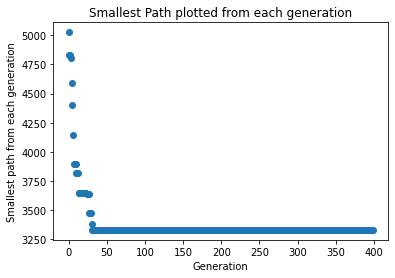

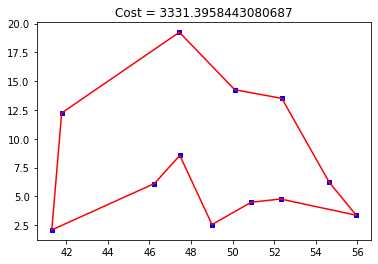

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7] 3331.3958443080687


In [10]:
###########################################################################
##### PART 10 =  IMPORTANT ## Input the data for the problem

# Co-ordinates for cities
g = Graph([
(55.9508, 3.3615),    #1 Edinburgh 
(47.4385, 19.2523),   #2 Budapest
(46.2370,6.1091),     #3 Geneva
(49.0097,2.5480),     #4 Paris
(50.9010, 4.4856),    #5 Brussels
(47.4612,8.5535),     #6 Zurich 
(52.3105,4.7683),     #7 Amsterdam
(41.7735,12.2397),    #8 Rome
(50.1018,14.2632),    #9 Prague
(54.6557, 6.2169),    #10 Belfast
(52.3733, 13.5064),   #11 Berlin 
(41.2974,2.0833),     #12 Barcelona
])

###########################################################################
##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
ga.run()


########## Output
best_tour = ga.best()
g.plot(best_tour)   #Plots the path on a graph

best_path = best_tour.vertices
size = len (g.vertices)
for i in range(size-1):
    best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
best_path.insert(0,1)   #Adds start node to the list
print("\nBest route between the cities is:", best_path,best_tour._Tour__cost)   #Prints the best path and distance


# Air time to travel overall distance

In [11]:
# Time taken is Distance travelled per hour is 460 miles
air_time = best_tour._Tour__cost/460

print(f'\nTotal flight time between the destinations: {air_time} hour')


Total flight time between the destinations: 7.242164878930584 hour


# Calculate the total time which is airtime + time required at airport

In [13]:
# If approximate time taken at airport to including formalities and wait time
# Considered 1 hour at each airport
air_plus_airport_time = air_time + 12

print(f'\nTotal flight time between the destinations including time required at airport to \
complete the formalities: {air_plus_airport_time} hour')


Total flight time between the destinations including time required at airport to complete the formalities: 19.242164878930584 hour


# Run this algorthim to make sure it is not stuck in local optimum

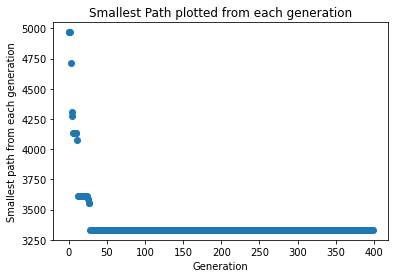

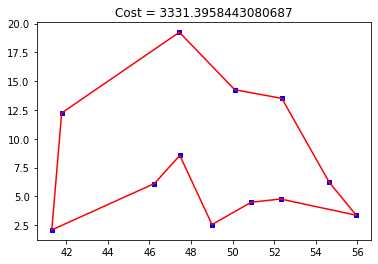

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


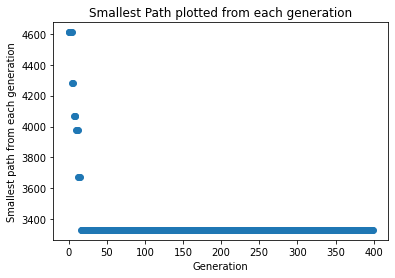

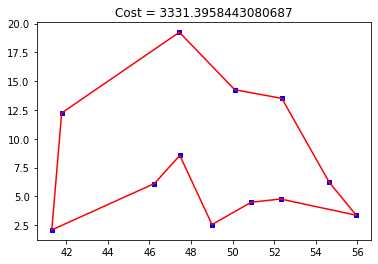

Vertices for locations are:
 [(55.9508, 3.3615), (52.3105, 4.7683), (50.901, 4.4856), (49.0097, 2.548), (47.4612, 8.5535), (46.237, 6.1091), (41.2974, 2.0833), (41.7735, 12.2397), (47.4385, 19.2523), (50.1018, 14.2632), (52.3733, 13.5064), (54.6557, 6.2169), (55.9508, 3.3615)]

Best route between the cities is: [1, 7, 5, 4, 6, 3, 12, 8, 2, 9, 11, 10] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


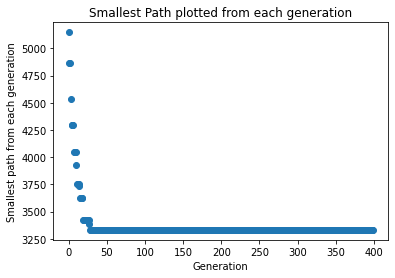

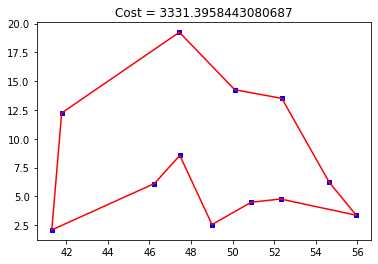

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


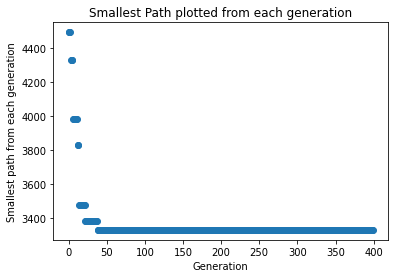

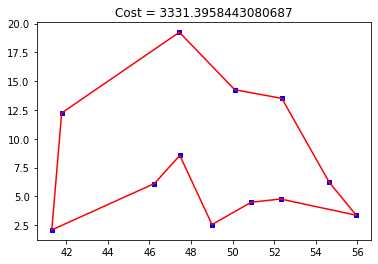

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


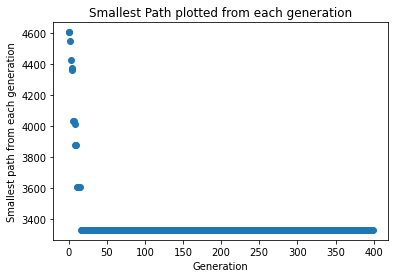

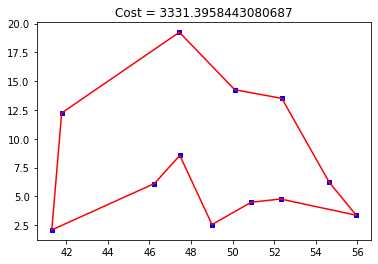

Vertices for locations are:
 [(55.9508, 3.3615), (52.3105, 4.7683), (50.901, 4.4856), (49.0097, 2.548), (47.4612, 8.5535), (46.237, 6.1091), (41.2974, 2.0833), (41.7735, 12.2397), (47.4385, 19.2523), (50.1018, 14.2632), (52.3733, 13.5064), (54.6557, 6.2169), (55.9508, 3.3615)]

Best route between the cities is: [1, 7, 5, 4, 6, 3, 12, 8, 2, 9, 11, 10] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


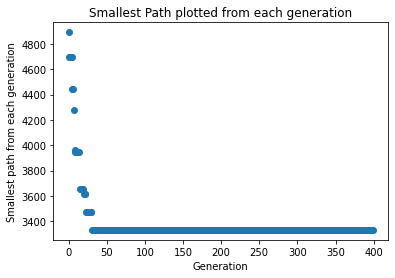

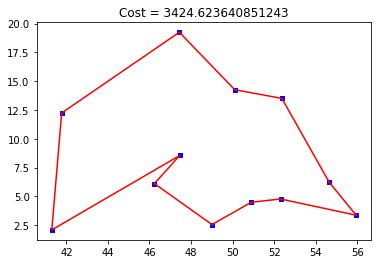

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (47.4612, 8.5535), (46.237, 6.1091), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 6, 3, 4, 5, 7] 3424.623640851243

Total flight time between the destinations: 7.444834001850529 hour


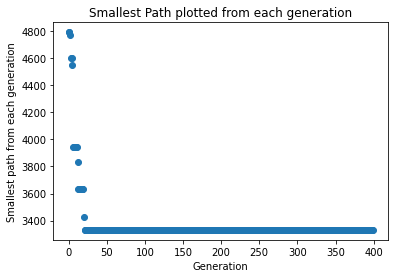

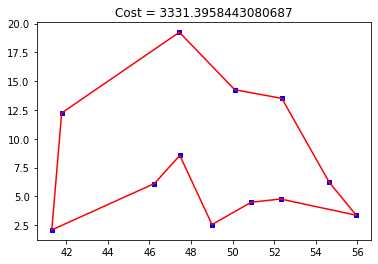

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


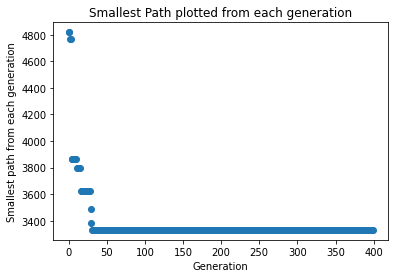

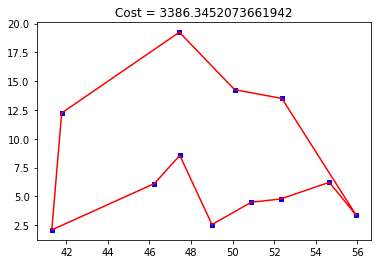

Vertices for locations are:
 [(55.9508, 3.3615), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (54.6557, 6.2169), (55.9508, 3.3615)]

Best route between the cities is: [1, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7, 10] 3386.3452073661942

Total flight time between the destinations: 7.3616200160134655 hour


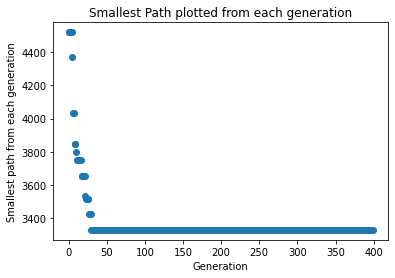

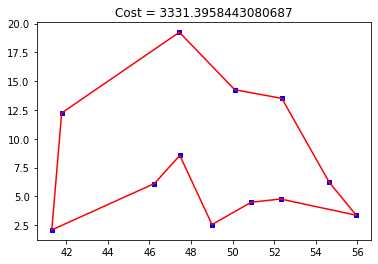

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (46.237, 6.1091), (47.4612, 8.5535), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 3, 6, 4, 5, 7] 3331.3958443080687

Total flight time between the destinations: 7.242164878930584 hour


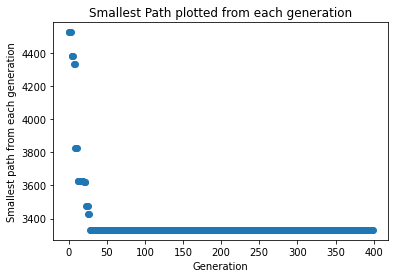

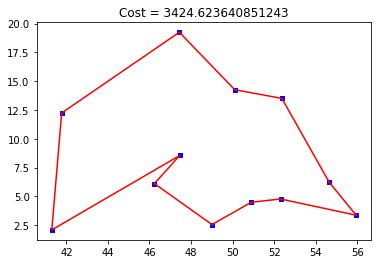

Vertices for locations are:
 [(55.9508, 3.3615), (54.6557, 6.2169), (52.3733, 13.5064), (50.1018, 14.2632), (47.4385, 19.2523), (41.7735, 12.2397), (41.2974, 2.0833), (47.4612, 8.5535), (46.237, 6.1091), (49.0097, 2.548), (50.901, 4.4856), (52.3105, 4.7683), (55.9508, 3.3615)]

Best route between the cities is: [1, 10, 11, 9, 2, 8, 12, 6, 3, 4, 5, 7] 3424.623640851243

Total flight time between the destinations: 7.444834001850529 hour


In [21]:
for i in range(10):
    ###########################################################################
    ##### PART 10 =  IMPORTANT ## Input the data for the problem

    # Co-ordinates for city
    g = Graph([
    (55.9508, 3.3615),    #1 Edinburgh 
    (47.4385, 19.2523),   #2 Budapest
    (46.2370,6.1091),     #3 Geneva
    (49.0097,2.5480),     #4 Paris
    (50.9010, 4.4856),    #5 Brussels
    (47.4612,8.5535),     #6 Zurich 
    (52.3105,4.7683),     #7 Amsterdam
    (41.7735,12.2397),    #8 Rome
    (50.1018,14.2632),    #9 Prague
    (54.6557, 6.2169),    #10 Belfast
    (52.3733, 13.5064),   #11 Berlin 
    (41.2974,2.0833),     #12 Barcelona
    ])

    ###########################################################################
    ##### PART 11 = IMPORTANT ## Runs the main GA (including population size)

    ga = GeneticAlgorithm(g, 100)    #Inputs (graph co-ordinates, POPULATION SIZE)  more = better, but takes longer
    ga.run()


    ########## Output
    best_tour = ga.best()
    g.plot(best_tour)   #Plots the path on a graph

    best_path = best_tour.vertices
    size = len (g.vertices)
    for i in range(size-1):
        best_path[i]=best_path[i]+1   #Must +1 to nodes to chnage numbering from (0,n-1) to (1,n)
    best_path.insert(0,1)   #Adds start node to the list
    print("\nBest route between the cities is:", best_path,best_tour._Tour__cost)   #Prints the best path and distance

    # Time taken is Distance travelled per hour is 460 miles
    air_time = best_tour._Tour__cost/460

    print(f'\nTotal flight time between the destinations: {air_time} hour')